In [13]:
import numpy as np
import pydot
from IPython.display import HTML, SVG

from manipulation import FindResource
from manipulation.scenarios import MakeManipulationStation

from pydrake.all import StartMeshcat
from pydrake.geometry import MeshcatVisualizer
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import (DiagramBuilder, 
                                      GenerateHtml)

In [5]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [6]:
station = MakeManipulationStation(
    filename=FindResource('models/clutter.dmd.yaml')
)
plant = station.GetSubsystemByName('plant')

In [7]:
builder = DiagramBuilder()
builder.AddSystem(station)

MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort('query_object'), meshcat
)

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.Initialize()

In [8]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
station_context = station.GetMyMutableContextFromRoot(context)

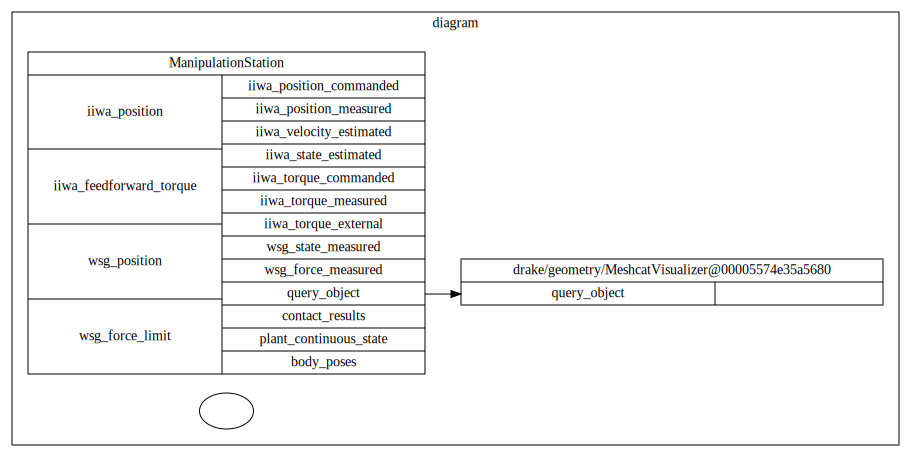

In [14]:
display(SVG(
    pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=1)
    )[0].create_svg()
))

In [22]:
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
iiwa = plant.GetModelInstanceByName("iiwa")
plant.SetPositions(plant_context, iiwa, q0)
station.GetOutputPort('iiwa_position_measured').Eval(station_context)

array([-1.57,  0.1 ,  0.  , -1.2 ,  0.  ,  1.6 ,  0.  ])

In [27]:
joint_angles = []
for i in range(1, 8):
    joint_angles.append(
            plant.GetJointByName(f'iiwa_joint_{i}').get_angle(plant_context)
    )

q_general = plant.GetPositions(plant_context, iiwa)
print(joint_angles)
print(q_general)

[-1.57, 0.1, 0.0, -1.2, 0.0, 1.6, 0.0]
[-1.57  0.1   0.   -1.2   0.    1.6   0.  ]


In [28]:
plant.SetVelocities(plant_context, iiwa, np.zeros(7,))

In [29]:
def get_velocity(station, station_context): 
    return station.GetOutputPort('iiwa_velocity_estimated').Eval(station_context)


In [31]:
from manipulation.exercises.robot.test_manipulation_io import TestManipulationIO
from manipulation.exercises.grader import Grader

Grader.grade_output([TestManipulationIO], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 5/5.

Score for Test get_velocity implementation is 5/5.


In [32]:
station.GetInputPort('iiwa_feedforward_torque').FixValue(
    station_context, np.zeros(7, )
)
tau_no_ff = station.GetOutputPort('iiwa_torque_commanded').Eval(station_context)

In [33]:
print('feedforward torque: {}'.format(np.zeros(7,)))
print('commanded torque with no feedforward torque:{}'.format(tau_no_ff))

feedforward torque: [0. 0. 0. 0. 0. 0. 0.]
commanded torque with no feedforward torque:[ 201.78302449 -304.19422994  180.39754534  260.12399618   23.98637583
 -155.37553482  -73.56331118]


In [39]:
# same of before, but different input torque
tau_ff = np.linspace(3.1, 3.7, 7)
station.GetInputPort("iiwa_feedforward_torque").FixValue(
    station_context, tau_ff)
torque_commanded = station.GetOutputPort("iiwa_torque_commanded").Eval(
    station_context)

print('feedforward torque: {}'.format(tau_ff))
print('the commanded torque: {}'.format(torque_commanded))

feedforward torque: [3.1 3.2 3.3 3.4 3.5 3.6 3.7]
the commanded torque: [ 204.88302449 -300.99422994  183.69754534  263.52399618   27.48637583
 -151.77553482  -69.86331118]
